In [187]:
# coding=utf-8
import math
from scapy.all import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
from scipy.stats import t
from math import sqrt
from math import pow
import requests
import os
import IP2Location
import matplotlib.patches as mpatches

IP_SERVICE_URL = 'https://freegeoip.net/json/{}'

#hosts = dict([('www.uq.edu.au','130.102.131.70'),('udsu.ru', '94.25.116.37'), ('site.u.pereslavl.ru','95.129.137.162'),('www.kstu.kz','85.29.137.233'), ('keu.kz','46.235.86.164'), ('unak.is','130.208.224.102'),('www.fu-berlin.de','160.45.170.10'),('kgiu.kz','195.210.46.14'),('www.uae.ma','159.253.148.195'),('unis.no','158.39.149.250'),('bifrost.is','185.118.33.147'),('birmingham.ac.uk','147.188.218.91')])
hosts = dict([('auckland.ac.nz', '130.216.159.127'), ('invertisuniversity.ac.in','103.241.146.22'), ('iups.edu', '23.236.62.147'),('realtyuniversal.com', '69.16.226.127')])
api_key = '49f2da642556dfd205946d37e9e7ebbd61d1e74ea737f153b597c212ea80302e'

DEFAULT_RTT_VALUE = 0

ATTEMPS = 30

In [188]:
from __future__ import print_function, unicode_literals, with_statement
import argparse
import contextlib
import requests
import sys
import csv
import matplotlib
# Anti-Grain Geometry (AGG) backend so PyGeoIpMap can be used 'headless'
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pygeoip


def get_ip(ip_file):
    """
    Returns a list of IP addresses from a file containing one IP per line.
    """
    with contextlib.closing(ip_file):
        return [line.strip() for line in ip_file]


def get_lat_lon(ip_list=[], lats=[], lons=[]):
    """
    This function connects to the FreeGeoIP web service to get info from
    a list of IP addresses.
    Returns two lists (latitude and longitude).
    """
    for ip in ip_list:
        r = requests.get("https://freegeoip.net/json/" + ip)
        json_response = r.json()
        if json_response['latitude'] and json_response['longitude']:
            print ("ip = {} lat = {} long = {}".format(ip, json_response['latitude'],json_response['longitude']))
            lats.append(json_response['latitude'])
            lons.append(json_response['longitude'])
    return lats, lons


def geoip_lat_lon(gi, ip_list):
    """
    This function uses the MaxMind library and databases to geolocate IP addresses
    Returns two lists (latitude and longitude).
    """
    lats=[]
    lons=[]
    for ip in ip_list:
        try:
            r = gi.record_by_addr(ip)
        except Exception:
            print("Unable to locate IP: %s" % ip)
            continue
        if r is not None:
            lats.append(r['latitude'])
            lons.append(r['longitude'])
    return lats, lons


def get_lat_lon_from_csv(csv_file, lats=[], lons=[]):
    """
    Retrieves the last two rows of a CSV formatted file to use as latitude
    and longitude.
    Returns two lists (latitudes and longitudes).
    Example CSV file:
    119.80.39.54, Beijing, China, 39.9289, 116.3883
    101.44.1.135, Shanghai, China, 31.0456, 121.3997
    219.144.17.74, Xian, China, 34.2583, 108.9286
    64.27.26.7, Los Angeles, United States, 34.053, -118.2642
    """
    with contextlib.closing(csv_file):
        reader = csv.reader(csv_file)
        for row in reader:
            lats.append(row[-2])
            lons.append(row[-1])

    return lats, lons


def generate_map(output, lats=[], lons=[], wesn=None):
    """
    Using Basemap and the matplotlib toolkit, this function generates a map and
    puts a red dot at the location of every IP addresses found in the list.
    The map is then saved in the file specified in `output`.
    """
    
    plt.close('all')
    print("Generating map and saving it to {}".format(output))
    if wesn:
        wesn = [float(i) for i in wesn.split('/')]
        m = Basemap(projection='cyl', resolution='l',
                llcrnrlon=wesn[0], llcrnrlat=wesn[2],
                urcrnrlon=wesn[1], urcrnrlat=wesn[3])
    else:
        m = Basemap(projection='cyl', resolution='l')
    m.bluemarble()

    x, y = m(lons, lats)
    
    m.plot(x, y, 40, 40, color='y')
    m.scatter(x, y, s=3, color='#ff0000', marker='o', alpha=0.3) #, alpha=0.3
    plt.savefig(output, dpi=300, bbox_inches='tight')
    plt.close('all')

def graficar_ruta(ruta, nombre_imagen):
    gi = pygeoip.GeoIP('GeoLiteCity.dat')
    lats, lons = geoip_lat_lon(gi,ruta)
    generate_map(nombre_imagen, lats, lons) #, wesn='-12/45/30/65'

In [189]:
def toLatex(df):
    from IPython.display import Latex
    return Latex(df.to_latex())

In [190]:
def ipCountryCode(ip):    
    resp = requests.get(IP_SERVICE_URL.format(ip))
    if resp.status_code != 200:
        raise ApiError('GET /tasks/ {}'.format(resp.status_code))
    return resp.json()['country_code']

In [191]:
def modified_thompson(n):
    alpha = 0.025
    t_critical = t.ppf(1-alpha, n-2)
    return (t_critical*(n-1)) / (sqrt(n) * sqrt(n-2 + pow(t_critical,2)))  

In [192]:
def enviar_paquete(host, time_to_live):
    packet = IP(dst=host, ttl=time_to_live) / ICMP()
    res = sr(packet, timeout=1, verbose=0)
    return res[0][ICMP]

In [193]:
def route(df):
    return df[df['ip'] != 'empty']['ip'].unique()

In [194]:
def calculateOutliers(rtt_df):
    descriptions = rtt_df.describe().T
    mean = descriptions['mean']
    std = descriptions['std']
    zrtt = (rtt_df-mean)/std
    n = len(zrtt)
    thomson_value = modified_thompson(n)
    abszrtt = abs(zrtt)
    return abszrtt[abszrtt['rtt'] > thomson_value], zrtt, thomson_value

In [197]:
def trace_route(hosts):
    
    ips_countrycode = {}
    df_list = []
    rtt_df_list = []
    outliers_df_list = []
    zrtt_df_list = []

    for host in hosts:
        hops = []
        ttl_without_response = []
        ip = hosts[host]
        for i in range(0,ATTEMPS):
            tipo = 11
            ttl = 1
            last_rtt = 0
            while (tipo!=0 and ttl < 30):
                if (not ttl in ttl_without_response):
                    ti = time.time()
                    res1 = enviar_paquete(ip, ttl)
                    tf = time.time()
                    rtt = tf-ti
                    if (len(res1) > 0):
                        tipo = res1[0][1].type
                        src = res1[0][1].src
                        countryCode = None
                        if(src in ips_countrycode):
                            countryCode = ips_countrycode[src]
                        else:
                            countryCode = ipCountryCode(src)
                            ips_countrycode[src] = countryCode
                        if (tipo > 0):
                            hops.append([host,ttl,i,src,countryCode, max(0,rtt-last_rtt)])
                        else:
                            hops.append([host,ttl,i,src,countryCode, max(0,rtt-last_rtt)])
                        last_rtt = rtt
                    else:
                        hops.append([host,ttl,i,"empty","empty",DEFAULT_RTT_VALUE])
                        ttl_without_response.append(ttl)
                ttl = ttl + 1

        df = pd.DataFrame(hops,columns=['host','ttl','i','ip','cc','rtt'])
        indexed = df.set_index(['host','ttl','i','ip','cc'])
        rtt_df = indexed.groupby(level=['host','ttl','ip','cc']).mean()
        outliers_df, zrtt_df, thompson_value = calculateOutliers(rtt_df)
        rtt_df_list.append(rtt_df)
        outliers_df_list.append(outliers_df)
        zrtt_df_list.append(zrtt_df)
        df_list.append(df)
        graficar_ruta(route(df),'route[{}].png'.format(host))
    
    return df_list, rtt_df_list, outliers_df_list, zrtt_df_list

# No ejecutar esto

In [198]:
%%time
df_list, rtt_df_list, outliers_df_list, zrtt_df_list = trace_route(hosts)

Generating map and saving it to route[invertisuniversity.ac.in].png
Generating map and saving it to route[auckland.ac.nz].png
Generating map and saving it to route[realtyuniversal.com].png
Generating map and saving it to route[iups.edu].png
CPU times: user 51.3 s, sys: 23.1 s, total: 1min 14s
Wall time: 13min 18s


# Guardo los archivos cvs

In [199]:
for df in df_list:
    host = df['host'].unique()[0]
    df.to_csv('./df-csv/'+host, index=False, header=None)

# Leo los archivos  csv y creo los dataframe

In [200]:
from os import listdir

def readDataFrames():
    df_map = {}
    rtt_df_map = {}
    outliers_df_map = {}
    zrtt_df_map = {}
    thompson_value_map = {}

    for host in listdir('./df-csv'):
        df = pd.read_csv('./df-csv/'+host, header=None, names=['host','ttl','i','ip','cc','rtt'])
        df_map[host] = df
        indexed = df.set_index(['host','ttl','i','ip','cc'])
        rtt_df = indexed.groupby(level=['host','ttl','ip','cc']).mean()
        outliers_df, zrtt_df, thompson_value = calculateOutliers(rtt_df)
        outliers_df_map[host] = outliers_df
        zrtt_df_map[host] = zrtt_df
        rtt_df_map[host] = rtt_df
        thompson_value_map[host] = thompson_value

    return df_map, rtt_df_map, outliers_df_map, zrtt_df_map, thompson_value_map


In [201]:
def graficarTodasLasCorridas(df_map):
    for host in df_map:
        graficar_ruta(route(df_map[host]), './grafico-rutas/'+host+'.png')

In [202]:
df_map, rtt_df_map, outliers_df_map, zrtt_df_map, thompson_value_map = readDataFrames()

In [203]:
graficarTodasLasCorridas(df_map)

Generating map and saving it to ./grafico-rutas/www.uq.edu.au.png
Generating map and saving it to ./grafico-rutas/unis.no.png
Generating map and saving it to ./grafico-rutas/udsu.ru.png
Generating map and saving it to ./grafico-rutas/www.kstu.kz.png
Generating map and saving it to ./grafico-rutas/auckland.ac.nz.png
Generating map and saving it to ./grafico-rutas/keu.kz.png
Generating map and saving it to ./grafico-rutas/bifrost.is.png
Generating map and saving it to ./grafico-rutas/unak.is.png
Generating map and saving it to ./grafico-rutas/site.u.pereslavl.ru.png
Generating map and saving it to ./grafico-rutas/www.uae.ma.png
Generating map and saving it to ./grafico-rutas/www.fu-berlin.de.png
Generating map and saving it to ./grafico-rutas/iups.edu.png
Generating map and saving it to ./grafico-rutas/invertisuniversity.ac.in.png
Generating map and saving it to ./grafico-rutas/kgiu.kz.png
Generating map and saving it to ./grafico-rutas/realtyuniversal.com.png
Generating map and saving i

In [204]:
rtt_df_map['auckland.ac.nz']

rtt
host           ttl ip              cc             
auckland.ac.nz 1   empty           empty  0.000000
               2   empty           empty  0.000000
               3   empty           empty  0.000000
               4   empty           empty  0.000000
               5   200.89.161.77   AR     0.076270
               6   200.89.165.197  AR     0.009660
               7   200.89.165.222  AR     0.010555
               8   empty           empty  0.000000
               9   67.17.94.249    US     0.116990
               10  empty           empty  0.000000
               11  empty           empty  0.000000
               12  4.68.127.54     US     0.008144
               13  129.250.4.250   US     0.008747
               14  129.250.2.219   US     0.026343
               15  129.250.7.69    US     0.013037
               16  129.250.3.123   US     0.005543
               17  204.1.253.166   US     0.045089
               18  202.158.194.172 AU     0.120172
               19  182.255.119.139 AU     0.014907
               20  210.7.39.251    NZ     0.014551
               21  210.7.39.178    NZ     0.004857
               22  empty           empty  0.000000
               23  empty           empty  0.000000
               24  empty           empty  0.000000
               25  empty           empty  0.000000
               26  empty           empty  0.000000
               27  empty           empty  0.000000
               28  empty           empty  0.000000
               29  empty           empty  0.000000

In [207]:
outliers_df_map['auckland.ac.nz']

rtt
host           ttl ip              cc          
auckland.ac.nz 9   67.17.94.249    US  3.078891
               18  202.158.194.172 AU  3.176235

In [206]:
thompson_value_map['auckland.ac.nz']

1.909649105843215

In [208]:
def generarHistogramas():    
    for host in zrtt_df_map:
        v = zrtt_df_map[host].plot(kind='hist', bins=30, title=host)
        l = v.axvline(x=thompson_value_map[host], linewidth=4, color='r')
        lines, labels = v.get_legend_handles_labels()
        labels.append('Thomson')
        v.legend(['Thompson', 'zrtt'])
        plt.savefig('./histogramas_thompson/'+host+'.png', dpi=300, bbox_inches='tight')
    

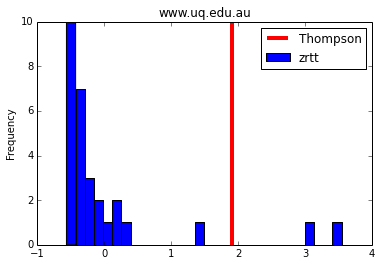

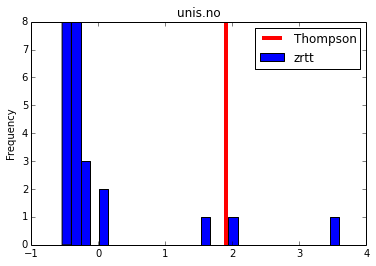

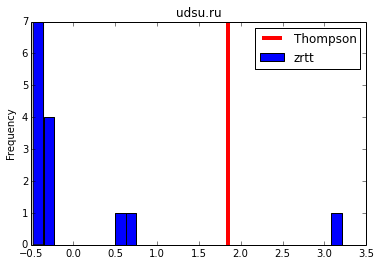

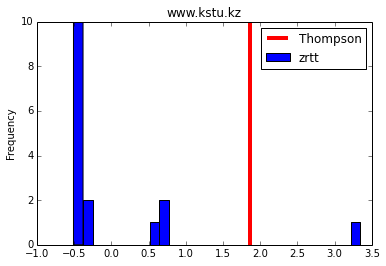

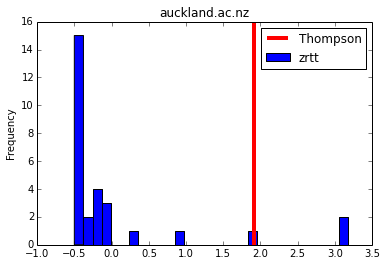

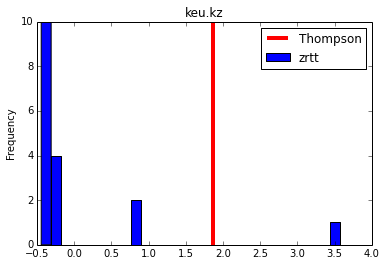

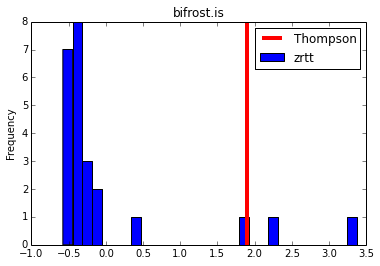

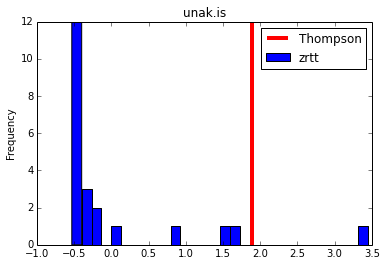

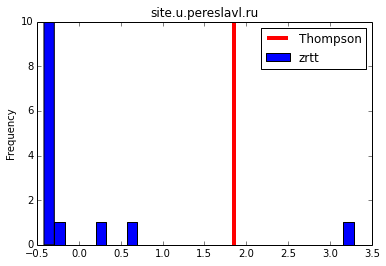

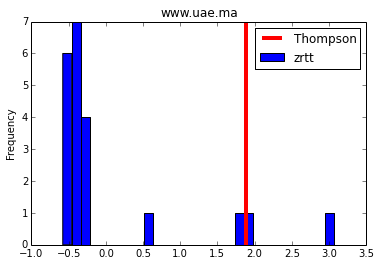

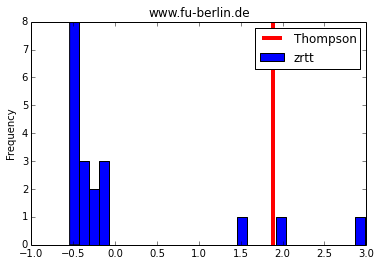

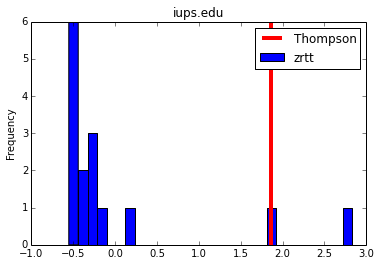

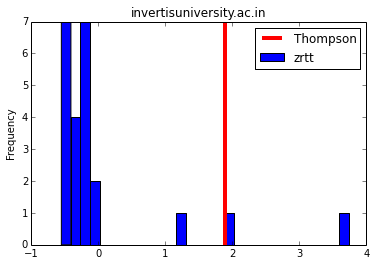

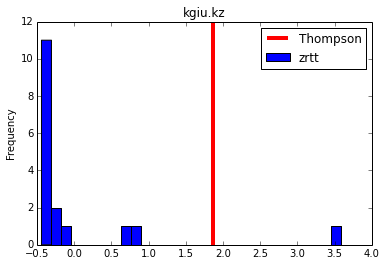

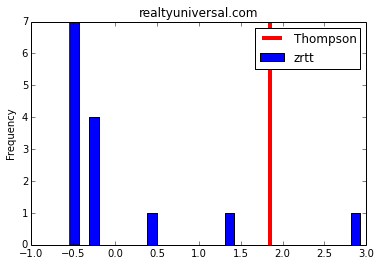

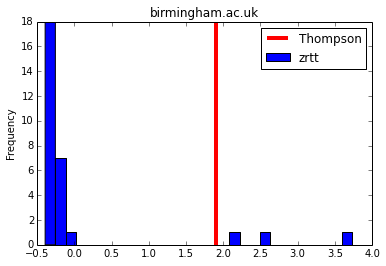

In [209]:
generarHistogramas()

In [ ]:
def generarHistogramasRtt():    
    for host in rtt_df_map:
        v = rtt_df_map[host].plot(kind='hist', bins=30, title=host)
        plt.savefig('./histogramas_rtt/'+host+'.png', dpi=300, bbox_inches='tight')

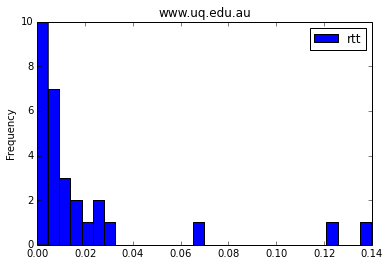

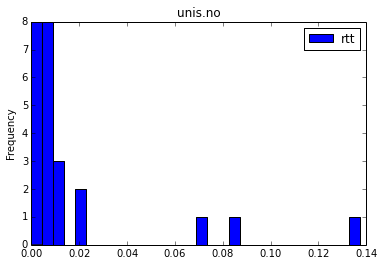

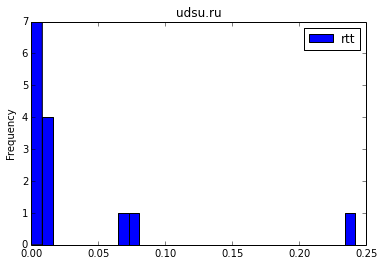

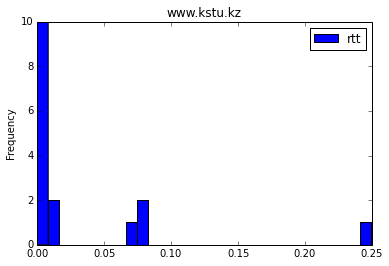

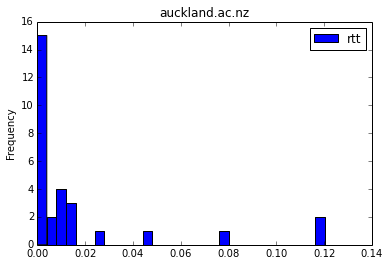

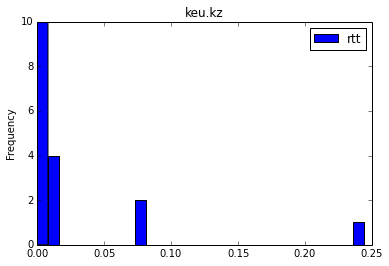

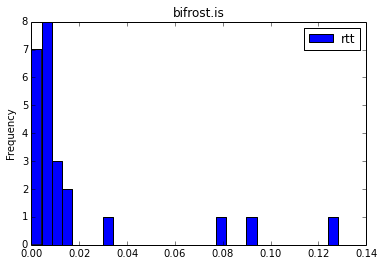

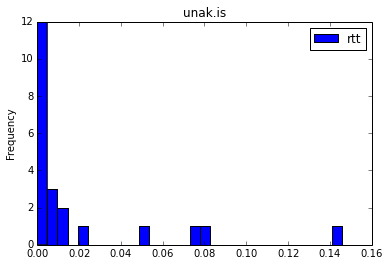

In [ ]:
generarHistogramasRtt()

array([[<matplotlib.axes.AxesSubplot object at 0x7f18b7450f10>]], dtype=object)

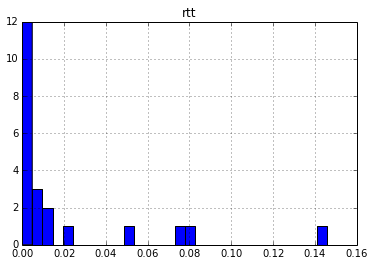

In [144]:
%matplotlib inline
rtt_df_map['unak.is']
pd.DataFrame.hist(rtt_df_map['unak.is'], bins=30)